In [6]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [7]:
temperatures = pd.read_csv('..\data\Average annual temperature central England 1723  1970.csv')
df = temperatures.set_index('temp').sort_index()
df.index = df.index.to_series().apply(lambda x: x + 1722)
df

,x
temp,
1723,9.77
1724,9.27
1725,8.66
1726,9.34
1727,9.94
...,...
1966,9.45
1967,9.61
1968,9.30


## Предсказание временного ряда с помощью деревьев

Попробуем обычное дерево решений и случайный лес, а потом сравним результаты

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [9]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [10]:
len(list_for_forecast)

247

In [11]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [12]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [13]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  0.5066144819505828


In [14]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 0.6298719232727223
MAPE: 0.054217981310494136
MAE: 0.5066144819505828
R2:  -0.45370547568357544


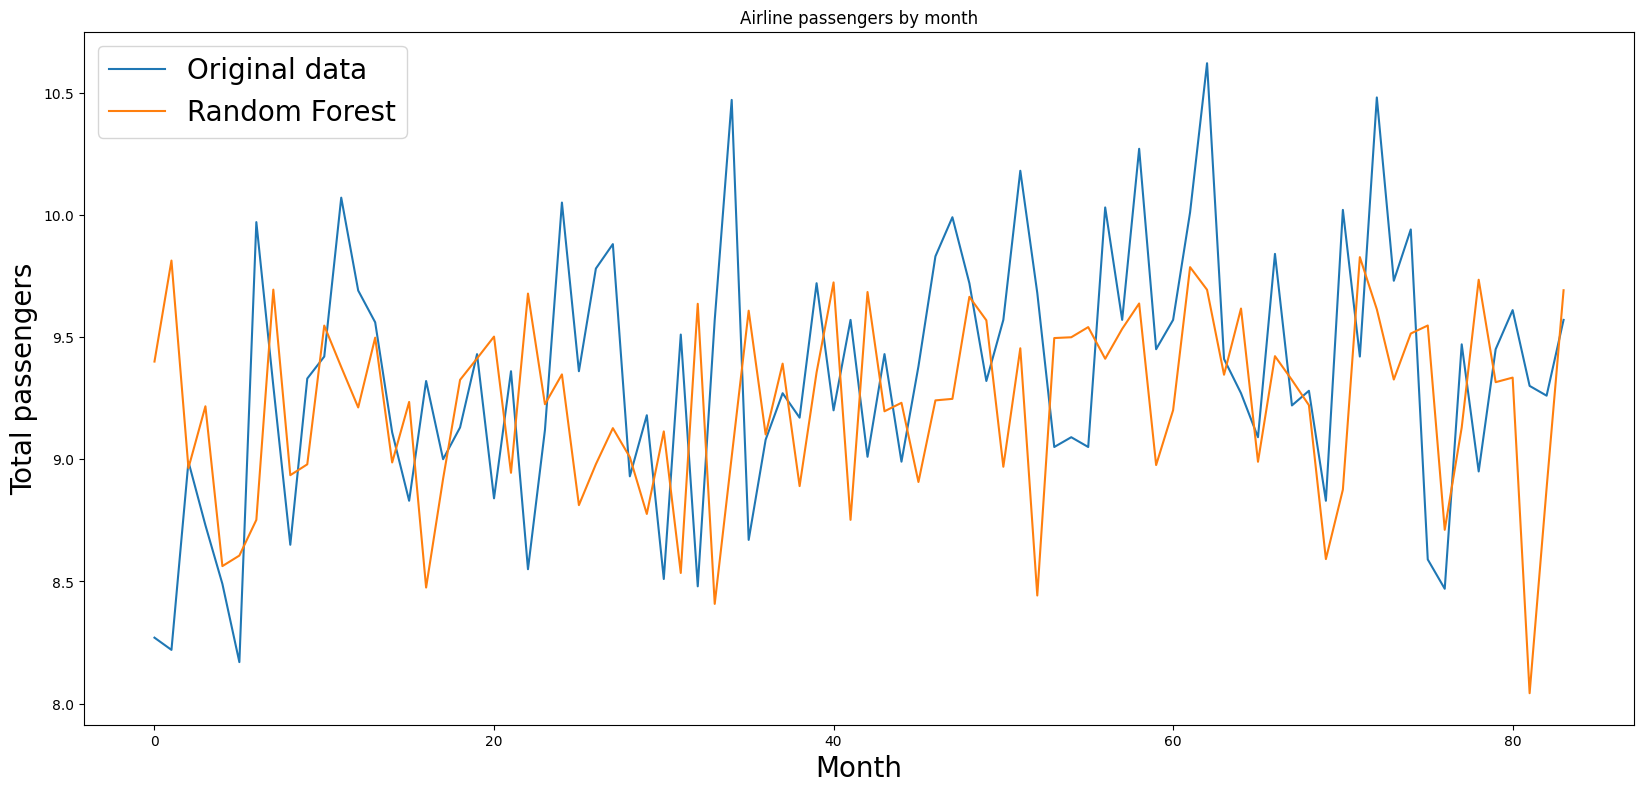

In [15]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Airline passengers by month')
plt.ylabel('Total passengers', fontsize="20")
plt.xlabel('Month', fontsize="20")
plt.show()

In [16]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])


In [17]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 0.6946668116202663
MAPE: 0.059555344733391274
MAE: 0.5556646825396825
R2:  -0.768174110677766


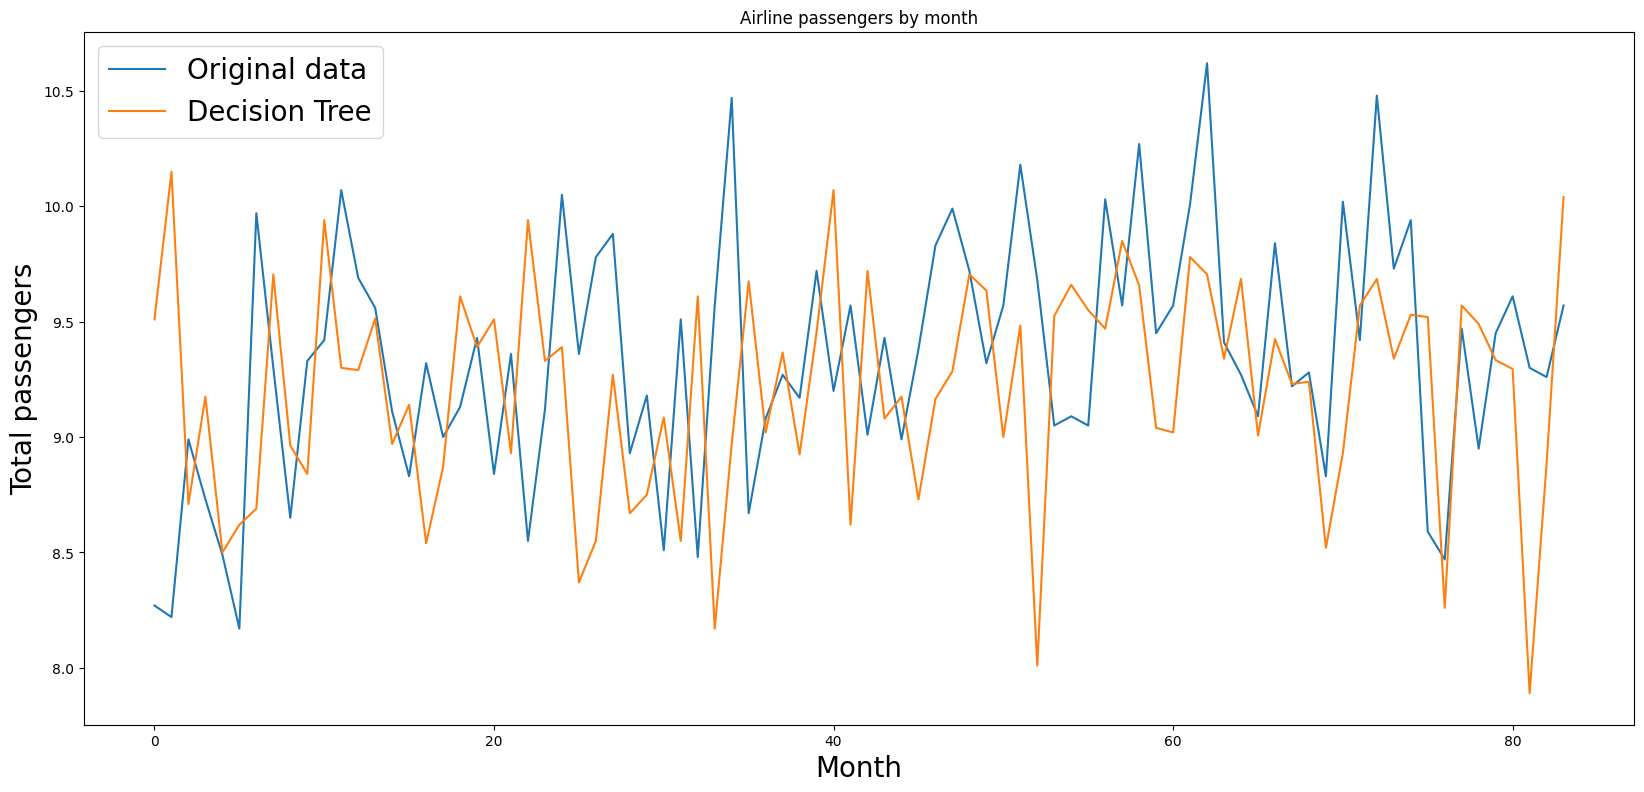

In [18]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Airline passengers by month')
plt.ylabel('Total passengers', fontsize="20")
plt.xlabel('Month', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

In [19]:
from sklearn.ensemble import IsolationForest

In [20]:
temperatures = pd.read_csv('..\data\Average annual temperature central England 1723  1970.csv')
df = temperatures.set_index('temp').sort_index()
df.index = df.index.to_series().apply(lambda x: x + 1722)
df

,x
temp,
1723,9.77
1724,9.27
1725,8.66
1726,9.34
1727,9.94
...,...
1966,9.45
1967,9.61
1968,9.30


In [21]:
model = IsolationForest(contamination=0.004)
model.fit(df[['x']])

IsolationForest(contamination=0.004)

In [23]:
df['outliers'] = pd.Series(model.predict(df[['x']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [24]:
df.query('outliers=="yes"')

,x,outliers
temp,,


In [26]:
fig = px.scatter(df.reset_index(), x='temp', y='x', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()